In [13]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
import pandas as pd

In [114]:
df = pd.read_csv('/content/drive/MyDrive/Year 4/NLP notebooks and data/Data/Preprocessed/with_topics_numeric.csv')

In [14]:
# Example sentiment labels (replace with actual data)
sentiments = ["Positive", "Negative", "Neutral"]
topic_sentiment_distribution = {
    "Room Quality": [50, 30, 20],
    "Service": [40, 25, 35],
    "Location": [60, 20, 20],
    "Food Quality": [30, 40, 30],
}

In [115]:
df.columns

Index(['helpfulVotes', 'id', 'address', 'city', 'placeName', 'numberOfReviews',
       'placeRating', 'webUrl', 'publishedDate', 'userRating', 'roomTip',
       'review_text', 'review_title', 'travelDate', 'tripType', 'username',
       'word_tokens', 'bpe_tokens', 'bigram_tokens', 'trigram_tokens',
       'whitespace_tokens', 'rule_based_tokens', 'spacy_tokens',
       'wordpiece_tokens', 'vader_score', 'compound_score', 'vader_category',
       'flair_sentiment', 'flair_confidence', 'textblob_sentiment',
       'ground_truth', 'assigned_topics'],
      dtype='object')

In [16]:
# Step 1: # Create the contingency table
contingency_table = pd.crosstab(df["Sentiment"], df["Assigned_Topic"])

# Display the contingency table
print(contingency_table)


,Room Quality,Service,Location,Food Quality
Positive,50,40,60,30
Negative,30,25,20,40
Neutral,20,35,20,30


In [17]:
# Step 2: Perform Chi-square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)


In [18]:
# Display Results
print("Observed Table:")
print(contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=sentiments, columns=topic_sentiment_distribution.keys()))
print(f"\nChi-square Statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")

Observed Table:
          Room Quality  Service  Location  Food Quality
Positive            50       40        60            30
Negative            30       25        20            40
Neutral             20       35        20            30

Expected Frequencies:
          Room Quality  Service  Location  Food Quality
Positive         45.00    45.00     45.00         45.00
Negative         28.75    28.75     28.75         28.75
Neutral          26.25    26.25     26.25         26.25

Chi-square Statistic: 25.15
p-value: 0.0003
Degrees of Freedom: 6


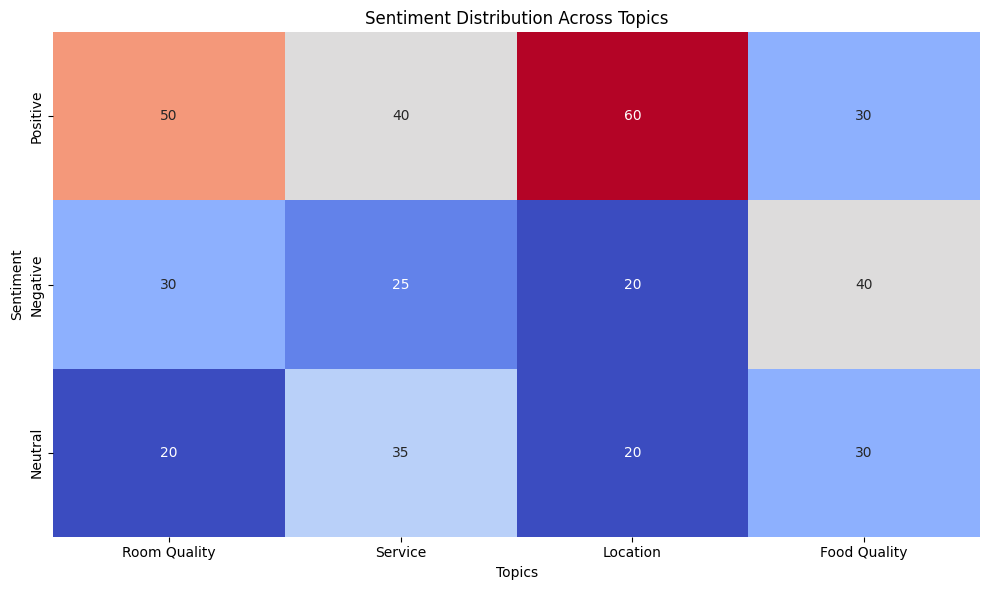

In [19]:
# Step 3: Visualize Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Sentiment Distribution Across Topics")
plt.ylabel("Sentiment")
plt.xlabel("Topics")
plt.tight_layout()
plt.show()

<ipython-input-20-bb0ef5c91740>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contingency_table.columns, y=contingency_table.sum(axis=0), palette="viridis")


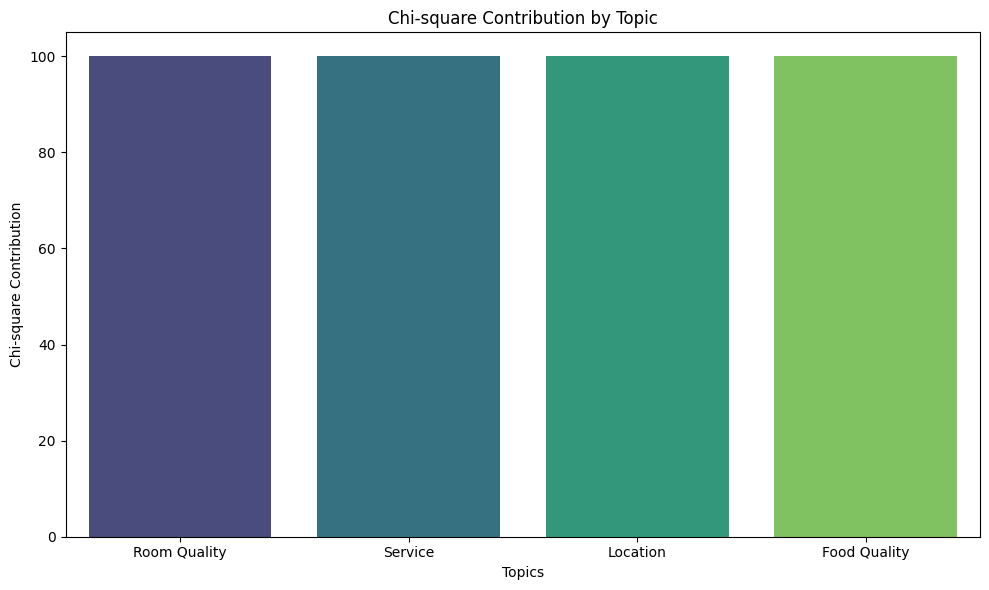

In [20]:
# Step 4: Visualize Chi-square Results
plt.figure(figsize=(10, 6))
sns.barplot(x=contingency_table.columns, y=contingency_table.sum(axis=0), palette="viridis")
plt.title("Chi-square Contribution by Topic")
plt.ylabel("Chi-square Contribution")
plt.xlabel("Topics")
plt.tight_layout()
plt.show()

# FastText + HDBSCAN

In [21]:
import numpy as np

In [22]:
from scipy.sparse import load_npz

In [106]:
df_labels = pd.read_csv('/content/drive/MyDrive/Year 4/NLP notebooks and data/Data/Preprocessed/with_topics_numeric.csv', index_col = 0)

In [107]:
df_labels.columns

Index(['id', 'address', 'city', 'placeName', 'numberOfReviews', 'placeRating',
       'webUrl', 'publishedDate', 'userRating', 'roomTip', 'review_text',
       'review_title', 'travelDate', 'tripType', 'username', 'word_tokens',
       'bpe_tokens', 'bigram_tokens', 'trigram_tokens', 'whitespace_tokens',
       'rule_based_tokens', 'spacy_tokens', 'wordpiece_tokens', 'vader_score',
       'compound_score', 'vader_category', 'flair_sentiment',
       'flair_confidence', 'textblob_sentiment', 'ground_truth',
       'assigned_topics'],
      dtype='object')

In [108]:
df = df_labels.loc[:,['placeRating','review_text','ground_truth','assigned_topics']]

In [67]:
# Load the NumPy array from the .npy file
drive_path = "/content/drive/MyDrive/Year 4/NLP notebooks and data/dense_vectors"
vec_type = 'word2vec'#'fasttext' #'word2vec' #
loaded_vectors = np.load(drive_path+f'/{vec_type}_vectors.npy')

In [35]:
# ! pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.1 MB/s eta 0:00:00


In [68]:
# HDBSCAN is a density-based clustering method that does not require the number of clusters in advance.
import hdbscan

# Fit HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                                    min_samples = 5,
                                    metric='euclidean',
                                    cluster_selection_epsilon=0.1 )
topics = hdbscan_clusterer.fit_predict(loaded_vectors)

# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics)) - (1 if -1 in topics else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 0


In [40]:
# Since the number of clusters are very low

In [69]:
from sklearn.preprocessing import normalize

X_fasttext = normalize(loaded_vectors)

In [70]:
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Experiment with values like 5, 10, 20
    min_samples=5,        # Lower this for higher sensitivity to small clusters
    metric='euclidean',   # Other options: 'cosine', 'manhattan'
    cluster_selection_epsilon=0.1  # Add if clusters are too sparse
)
topics_nomralized = hdbscan_clusterer.fit_predict(X_fasttext)


In [71]:
# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics_nomralized)) - (1 if -1 in topics_nomralized else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 4


In [72]:
from sklearn.decomposition import PCA

# Reduce dimensions to 50 before HDBSCAN
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_fasttext)

# Run HDBSCAN on reduced data
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
topics = hdbscan_clusterer.fit_predict(X_reduced)


In [73]:
# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics)) - (1 if -1 in topics else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 2


In [74]:
print(set(topics))


{0, 1, -1}


# Visualization

In [54]:
X_embedded.shape

(11808, 3)

## PCA

In [55]:
import random

In [ ]:
from sklearn.decomposition import PCA

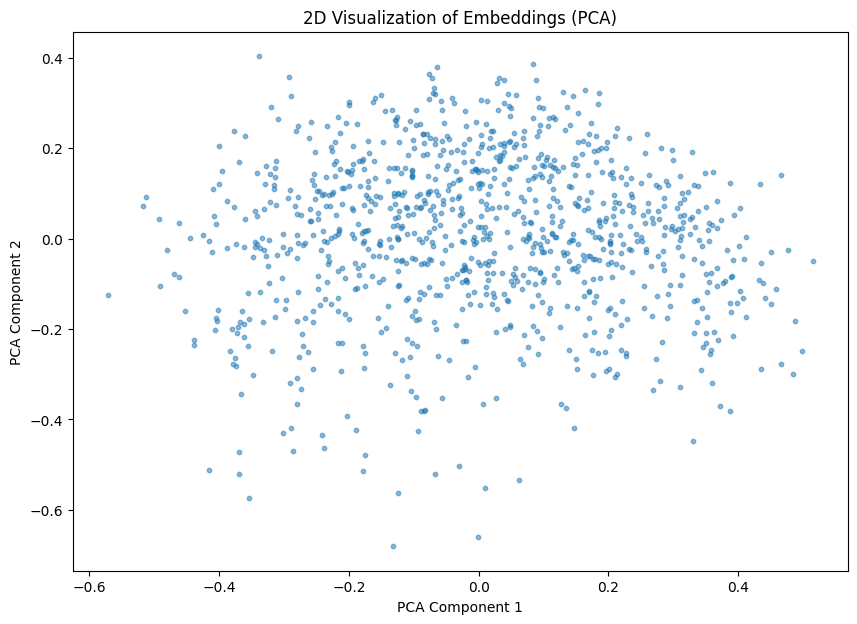

In [81]:
random_vectors = random.sample(range(11808), 1000)

# Reduce embeddings to 2D
pca = PCA(n_components=20)
X_embedded = pca.fit_transform(X_fasttext)

# Plot the reduced embeddings
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[random_vectors, 0], X_embedded[random_vectors, 1], alpha=0.5, s=10)
plt.title("2D Visualization of Embeddings (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [83]:
fasttext_vectors = X_fasttext
sentiments = df['ground_truth']

In [85]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fasttext_vectors)

# Map sentiments to colors
sentiment_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
colors = [sentiment_colors[s] for s in sentiments]

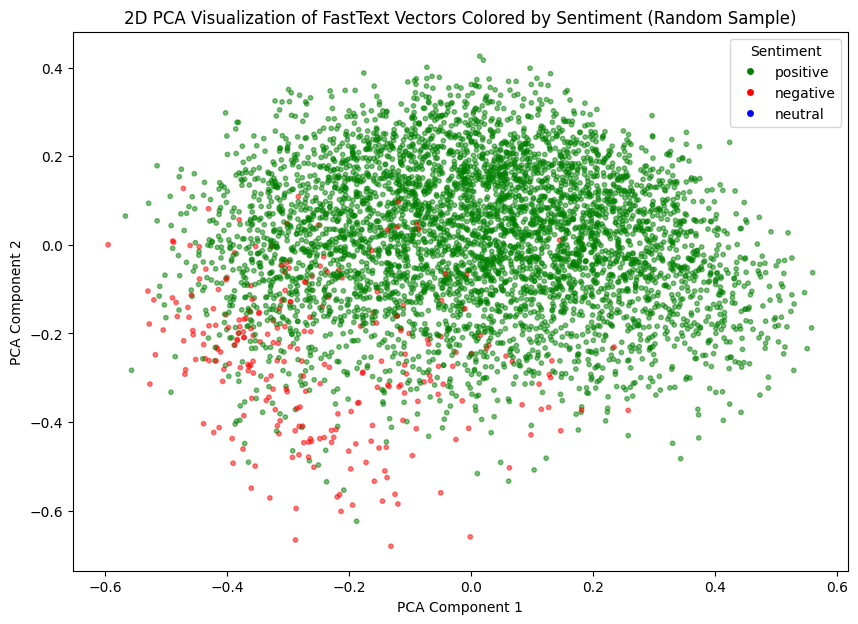

In [92]:
# Generate random indices
random.seed(42)  # Set a seed for reproducibility
random_vectors = random.sample(range(X_pca.shape[0]), 5000)  # Randomly sample 100 indices

# Subset PCA components and corresponding colors using the random indices
X_pca_subset = X_pca[random_vectors]
colors_subset = [colors[i] for i in random_vectors]

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], c=colors_subset, alpha=0.5, s=10)
plt.title("2D PCA Visualization of FastText Vectors Colored by Sentiment (Random Sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v)
                     for k, v in sentiment_colors.items()],
           title="Sentiment")
plt.show()


## TSNE

In [103]:
from sklearn.manifold import TSNE

In [116]:
# Fit t-SNE to the embeddings
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_fasttext)

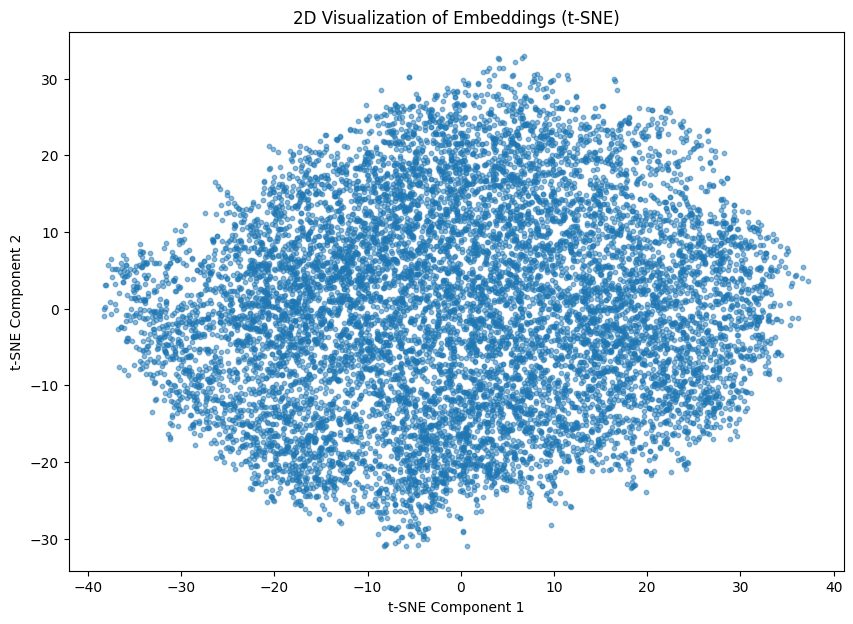

In [117]:
# Plot the t-SNE projection
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10)
plt.title("2D Visualization of Embeddings (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

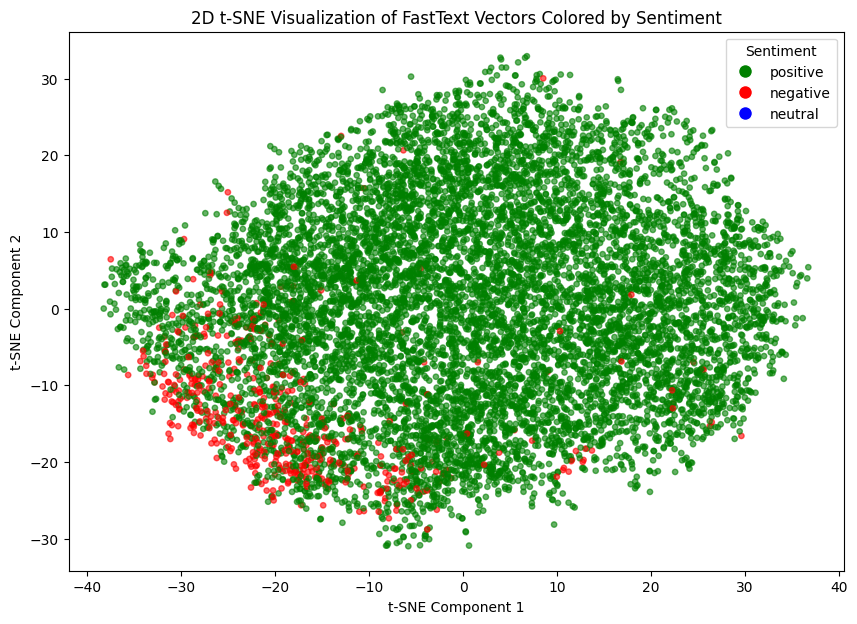

In [118]:
# Define sentiment colors
sentiment_colors = {
    "positive": "green",
    "negative": "red",
    "neutral": "blue"
}

# Map sentiment labels to colors
colors = [sentiment_colors[sent] for sent in sentiments]

# Randomly sample 1000 points for visualization
random_indices = random.sample(range(X_tsne.shape[0]), min(10000, X_tsne.shape[0]))

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[random_indices, 0], X_tsne[random_indices, 1],
            c=np.array(colors)[random_indices], alpha=0.6, s=15)
plt.title("2D t-SNE Visualization of FastText Vectors Colored by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
                     for k, v in sentiment_colors.items()],
           title="Sentiment", loc="best")
plt.show()


In [122]:
# Define topic colors (example: topics 0 to 9)
num_topics = df['assigned_topics'].nunique()  # Get the number of unique topics
topic_colors = {topic: plt.cm.tab10(topic % 10) for topic in range(num_topics)}  # Use tab10 colormap
# Map topics to colors
colors = [topic_colors[topic] for topic in df['assigned_topics']]

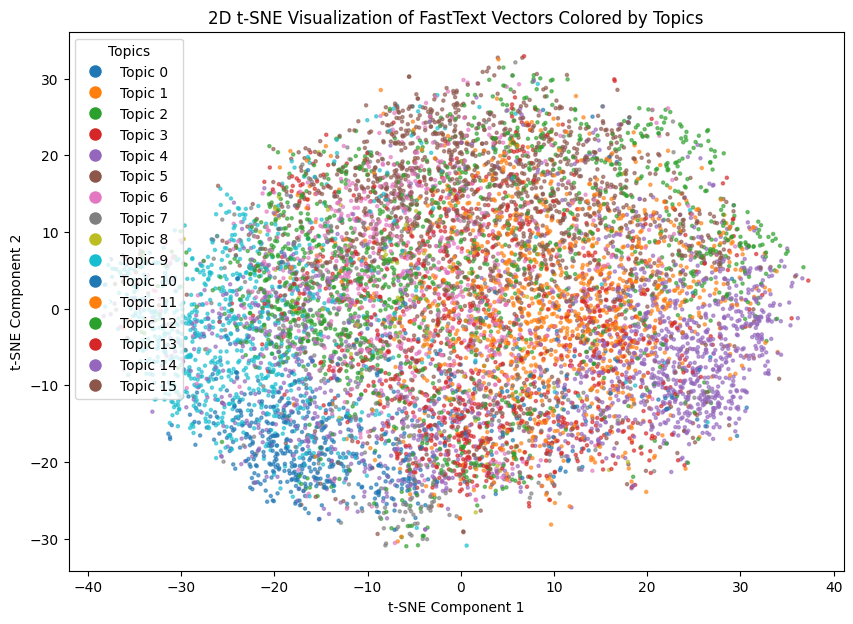

In [124]:
# Randomly sample points for visualization (e.g., 1000 points)
random_indices = random.sample(range(X_tsne.shape[0]), min(10000, X_tsne.shape[0]))

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[random_indices, 0], X_tsne[random_indices, 1],
            c=np.array(colors)[random_indices], alpha=0.6, s=5)
plt.title("2D t-SNE Visualization of FastText Vectors Colored by Topics")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add legend for topics
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {k}", markerfacecolor=v, markersize=10)
                     for k, v in topic_colors.items()],
           title="Topics", loc="best")
plt.show()
